In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import string
import re

import scipy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import torchsummary

import time
import os
import shutil

import transformers
from transformers import BertTokenizer, BertModel

from tqdm.notebook import tqdm
tqdm.pandas()

device="cuda"

# Load Datasets
1. Load the datasets
2. Verify no article bodies overlap

In [2]:
train_stances = pd.read_csv("./dataset/train_stances.csv")
train_bodies = pd.read_csv("./dataset/train_bodies.csv")

test_stances = pd.read_csv("./dataset/competition_test_stances.csv")
test_bodies = pd.read_csv("./dataset/competition_test_bodies.csv")

In [3]:
train_stances["Headline"].value_counts()

ISIL Beheads American Photojournalist in Iraq                                                      127
WHO says reports of suspected Ebola cases in Iraq are untrue                                       124
James Foley remembered as 'brave and tireless' journalist                                          121
Islamic Militants Post Video Claiming to Show Beheading of U.S. Journalist                         118
US officials: Video shows American's execution                                                     112
                                                                                                  ... 
Apple hopes to sell over 50 million watches in 2015                                                  2
Mom Calls 911 On Masturbating Teenage Son; Boy Arrested, Charged With New ‘Self-Rape’ State Law      2
Federal Judge: Enough With the Stupid Names                                                          2
Sushi lover's entire body left riddled with WORMS after eating contaminat

In [4]:
test_stances["Headline"].value_counts()

Source: Joan Rivers' doc did biopsy, selfie                                                                                                                  160
Joan Rivers Personal Doctor Allegedly Took A Selfie Before Her Biopsy And Cardiac Arrest                                                                     138
‘Three-boobed’ woman: They’re not fake                                                                                                                        92
Adopting Potential Werewolves Is Routine Business for Argentine Presidents                                                                                    92
Justin Bieber Basically Saves A Russian Man From A Bear                                                                                                       88
                                                                                                                                                            ... 
Madonna pledges oral sex for Clint

In [5]:
train_stances.loc[train_stances["Headline"].isin(test_stances["Headline"])]

,Headline,Body ID,Stance
173,Cheese addiction breaks Kim Jong-un's ankles,2210,unrelated
1415,WSJ: Apple cut watch health features due to er...,1917,discuss
1418,Cheese blamed for North Korean leader Kim Jong...,1689,unrelated
1479,Cheese blamed for North Korean leader Kim Jong...,186,unrelated
1503,Cheese addiction breaks Kim Jong-un's ankles,2329,unrelated
...,...,...,...
48270,Apple was forced to nix key health features fr...,407,discuss
48852,Cheese blamed for North Korean leader Kim Jong...,2042,unrelated
49279,Cheese addiction breaks Kim Jong-un's ankles,1854,discuss
49349,Cheese blamed for North Korean leader Kim Jong...,2344,unrelated


In [6]:
train_stances.loc[train_stances["Body ID"].isin(test_stances["Body ID"])]

,Headline,Body ID,Stance


So there is overlap of the headlines in both the training and the test data but there is no overlap with the bodies of the articles so we should split the training set into training and validation such that the bodies of the articles are disjoint.

In [7]:
test_df = test_stances.merge(test_bodies, on="Body ID")
test_df["Related"] = (test_df["Stance"] != "unrelated").astype(int)

In [8]:
test_df

,Headline,Body ID,Stance,articleBody,Related
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...,0
1,Apple Stores to install safes to secure gold A...,2008,unrelated,A RESPECTED senior French police officer inves...,0
2,Pregnant woman loses eye after police shoot be...,2008,unrelated,A RESPECTED senior French police officer inves...,0
3,We just found out the #Ferguson Protester who ...,2008,unrelated,A RESPECTED senior French police officer inves...,0
4,Police Chief In Charge of Paris Attacks Commit...,2008,discuss,A RESPECTED senior French police officer inves...,1
...,...,...,...,...,...
25408,A Sign That Obamacare Exchanges Are Failing,2586,disagree,Remember how much Republicans wanted to repeal...,1
25409,Republicans call Obamacare a 'failure.' These ...,2586,agree,Remember how much Republicans wanted to repeal...,1
25410,CBO’s Alternate Facts Show Obamacare is Unsust...,2586,disagree,Remember how much Republicans wanted to repeal...,1
25411,Why Obamacare failed,2586,disagree,Remember how much Republicans wanted to repeal...,1


In [9]:
train_and_val_df = train_stances.merge(train_bodies, on="Body ID")
train_and_val_df["Related"] = (train_and_val_df["Stance"] != "unrelated").astype(int)

# Exploratory Data Analysis
TODO: Data analysis

In [10]:
train_and_val_df

,Headline,Body ID,Stance,articleBody,Related
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,0
...,...,...,...,...,...
49967,Amazon Is Opening a Brick-and-Mortar Store in ...,464,agree,"Amazon, the cyber store that sells everything,...",1
49968,Elon University has not banned the term ‘fresh...,362,agree,"ELON, N.C. – A recent rumor claims that Elon U...",1
49969,Fake BBC News website set up to carry Charlie ...,915,agree,A realistic-looking fake BBC News website has ...,1
49970,Apple was forced to nix key health features fr...,407,discuss,The health-focused smartwatch that Apple initi...,1


Drop all rows that are unrelated

In [11]:
train_and_val_df = train_and_val_df[train_and_val_df["Related"] == True]

In [12]:
train_and_val_df

,Headline,Body ID,Stance,articleBody,Related
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
5,Return of the Mac: Seth Rogen in talks to star...,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
6,Seth Rogen Is Woz,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
15,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
20,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,712,discuss,Danny Boyle is directing the untitled film\r\n...,1
...,...,...,...,...,...
49967,Amazon Is Opening a Brick-and-Mortar Store in ...,464,agree,"Amazon, the cyber store that sells everything,...",1
49968,Elon University has not banned the term ‘fresh...,362,agree,"ELON, N.C. – A recent rumor claims that Elon U...",1
49969,Fake BBC News website set up to carry Charlie ...,915,agree,A realistic-looking fake BBC News website has ...,1
49970,Apple was forced to nix key health features fr...,407,discuss,The health-focused smartwatch that Apple initi...,1


In [13]:
test_df = test_df[test_df["Related"] == True]

In [14]:
test_df

,Headline,Body ID,Stance,articleBody,Related
4,Police Chief In Charge of Paris Attacks Commit...,2008,discuss,A RESPECTED senior French police officer inves...,1
8,Police officer in Charlie Hebdo investigation ...,2008,discuss,A RESPECTED senior French police officer inves...,1
11,Top cop investigating Charlie Hebdo attacks ki...,2008,discuss,A RESPECTED senior French police officer inves...,1
13,New Twist: Charlie Hebdo Police Investigator T...,2008,discuss,A RESPECTED senior French police officer inves...,1
35,Report: Apple May Buy Social Network Path,1550,discuss,Dave Morin's social networking company Path is...,1
...,...,...,...,...,...
25408,A Sign That Obamacare Exchanges Are Failing,2586,disagree,Remember how much Republicans wanted to repeal...,1
25409,Republicans call Obamacare a 'failure.' These ...,2586,agree,Remember how much Republicans wanted to repeal...,1
25410,CBO’s Alternate Facts Show Obamacare is Unsust...,2586,disagree,Remember how much Republicans wanted to repeal...,1
25411,Why Obamacare failed,2586,disagree,Remember how much Republicans wanted to repeal...,1


# Data Splitting
Now we need to split the training data into a training and validation set. We leave the test set untouched in this respect.

In [15]:
val_split_ratio = 0.2

In [16]:
def split_train_val(df, ratio):
    val_count = int(ratio * df["Body ID"].nunique())
    all_ids = list(df["Body ID"].unique())
    val_body_ids = random.sample(all_ids, val_count)
    train_body_ids = set(all_ids) - set(val_body_ids)
    
    assert len(set(val_body_ids) & train_body_ids) == 0
    
    val_df = df.loc[df["Body ID"].isin(val_body_ids)]
    train_df = df.loc[df["Body ID"].isin(train_body_ids)]
    
    return val_df, train_df

In [17]:
val_df, train_df = split_train_val(train_and_val_df, val_split_ratio)

In [18]:
val_df["Body ID"].nunique()

336

In [19]:
test_df["Body ID"].nunique()

904

In [20]:
train_df["Body ID"].nunique()

1347

In [21]:
def prepare_df(df):
    df = df.drop("Body ID", axis=1)
    df = df.reset_index()
    df = df.drop("index", axis=1)
    df["Related"] = df["Stance"] != "unrelated"
    return df

In [22]:
val_df = prepare_df(val_df)
train_df = prepare_df(train_df)
test_df = prepare_df(test_df)

In [23]:
val_df["Stance"].value_counts(normalize=True)#.plot(kind="bar")

discuss     0.674624
agree       0.270290
disagree    0.055086
Name: Stance, dtype: float64

In [24]:
train_df["Stance"].value_counts(normalize=True)#.plot(kind="bar")

discuss     0.660688
agree       0.274851
disagree    0.064462
Name: Stance, dtype: float64

In [25]:
test_df["Stance"].value_counts(normalize=True)#.plot(kind="bar")

discuss     0.631937
agree       0.269394
disagree    0.098669
Name: Stance, dtype: float64

# Clean the Data
Now we have the data, need to clean the data and extract the TF-IDF features. Basic things to consider doing:
* Remove punctuation
* Remove URLs
* Remove HTML
* Remove numbers
* Remove emojis
* Convert to lowercase

And we should also:
* Tokenise
* Remove stopwords
* Lemmatisation or Stemming

In [26]:
# Most of this from the first practical
additional_specials = ["—", "”", "“", "’", "‘"]

def remove_excess_whitespace(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("\r", " ")
    text = text.strip()
    return text

def remove_punctuation(text):
    punc = str.maketrans('', '', string.punctuation)
    text = text.translate(punc)
    
    for special in additional_specials:
        text = text.replace(special, "")
    
    return text

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)

def remove_numbers(text):
    numbers = re.compile(r'\d+')
    return numbers.sub('', text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

def apply_cleaning(text, excess=True, punc=True, urls=True, html=True, numbers=True, emojis=True, lower=True):
    if excess:
        text = " ".join(text.split())
        
    if punc:
        text = remove_punctuation(text)
    
    if urls:
        text = remove_urls(text)
    
    if html:
        text = remove_html(text)
    
    if numbers:
        text = remove_numbers(text)
        
    if emojis:
        text = remove_emojis(text)
        
    if lower:
        text = text.lower()
    
    return text

In [27]:
config_remove_excess_whitespace = True
config_remove_punctuation = False
config_remove_urls = True
config_remove_html = True
config_remove_numbers = False
config_remove_emojis = True
config_convert_to_lowercase = False

In [28]:
def process_text(text):
    text = apply_cleaning(
        text, 
        excess=config_remove_excess_whitespace, 
        punc=config_remove_punctuation, 
        urls=config_remove_urls, 
        html=config_remove_html, 
        numbers=config_remove_numbers, 
        emojis=config_remove_emojis, 
        lower=config_convert_to_lowercase
    )
    
    return text

In [29]:
test_text = train_df.iloc[812]["articleBody"]
print("Unprocessed:")
print(test_text)
print()
test_processed = process_text(test_text)
print("Processed:")
print(test_processed)

Unprocessed:
It's not exactly legalization, but in New York City it could become the next best thing: tickets for marijuana possession instead of arrests.

According to a report on Sunday from The New York Times, the New York Police Department (NYPD) is planning to announce new guidelines that would allow those found in possession of small amounts of marijuana to walk away with a ticket instead of spending time in handcuffs.

The change in policy could have wide-ranging effects in a city known for arresting thousands citizens each year for marijuana possession.

If true, the change in policy could also have a significant impact on the city's black and Hispanic community, which some studies say are disproportionately affected by the police department's current marijuana arrest policy.

The upcoming shift in enforcement, which the report says is something of a throwback to the city's policy in the late '70s, comes just days after Alaska, Oregon and Washington D.C. voted to legalize canna

In [30]:
train_df

,Headline,Stance,articleBody,Related
0,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True
1,Return of the Mac: Seth Rogen in talks to star...,discuss,Danny Boyle is directing the untitled film\r\n...,True
2,Seth Rogen Is Woz,discuss,Danny Boyle is directing the untitled film\r\n...,True
3,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,discuss,Danny Boyle is directing the untitled film\r\n...,True
4,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,discuss,Danny Boyle is directing the untitled film\r\n...,True
...,...,...,...,...
10699,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True
10700,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True
10701,Elon University has not banned the term ‘fresh...,agree,"ELON, N.C. – A recent rumor claims that Elon U...",True
10702,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True


In [31]:
train_df["Processed Headline"] = train_df["Headline"].progress_apply(process_text)
train_df["Processed Body"] = train_df["articleBody"].progress_apply(process_text)

  0%|          | 0/10704 [00:00<?, ?it/s]

  0%|          | 0/10704 [00:00<?, ?it/s]

In [32]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...
1,Return of the Mac: Seth Rogen in talks to star...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Return of the Mac: Seth Rogen in talks to star...,Danny Boyle is directing the untitled film Set...
2,Seth Rogen Is Woz,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Is Woz,Danny Boyle is directing the untitled film Set...
3,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,Danny Boyle is directing the untitled film Set...
4,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,Danny Boyle is directing the untitled film Set...
...,...,...,...,...,...,...
10699,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...
10700,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,..."
10701,Elon University has not banned the term ‘fresh...,agree,"ELON, N.C. – A recent rumor claims that Elon U...",True,Elon University has not banned the term ‘fresh...,"ELON, N.C. – A recent rumor claims that Elon U..."
10702,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...


In [33]:
val_df["Processed Headline"] = val_df["Headline"].progress_apply(process_text)
val_df["Processed Body"] = val_df["articleBody"].progress_apply(process_text)

  0%|          | 0/2723 [00:00<?, ?it/s]

  0%|          | 0/2723 [00:00<?, ?it/s]

In [34]:
val_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Breaking: Soldier shot at National War Memoria...,discuss,(Reuters) - A Canadian soldier was shot at the...,True,Breaking: Soldier shot at National War Memoria...,(Reuters) - A Canadian soldier was shot at the...
1,A soldier has been shot at Canada’s war memori...,discuss,(Reuters) - A Canadian soldier was shot at the...,True,A soldier has been shot at Canada’s war memori...,(Reuters) - A Canadian soldier was shot at the...
2,There has been a shooting at the War Memorial ...,discuss,(Reuters) - A Canadian soldier was shot at the...,True,There has been a shooting at the War Memorial ...,(Reuters) - A Canadian soldier was shot at the...
3,Soldier shot near Canadian parliament building,discuss,(Reuters) - A Canadian soldier was shot at the...,True,Soldier shot near Canadian parliament building,(Reuters) - A Canadian soldier was shot at the...
4,Banksy 'Arrested & Real Identity Revealed' Is ...,agree,If you’ve seen a story floating around on your...,True,Banksy 'Arrested & Real Identity Revealed' Is ...,If you’ve seen a story floating around on your...
...,...,...,...,...,...,...
2718,"Is Apple about to launch a totally redesigned,...",discuss,"Every year, Apple does some counterprogramming...",True,"Is Apple about to launch a totally redesigned,...","Every year, Apple does some counterprogramming..."
2719,Chinese 'mistress' is stripped naked and beate...,agree,She was violently stripped naked and beaten se...,True,Chinese 'mistress' is stripped naked and beate...,She was violently stripped naked and beaten se...
2720,Predator drones being flown over Isil's Syrian...,agree,"US drones are being flown over Isil's Syrian ""...",True,Predator drones being flown over Isil's Syrian...,"US drones are being flown over Isil's Syrian ""..."
2721,"NASA: Planetary Alignment On Jan 4, 2015 Will ...",discuss,via Daily Buzz Live\r\n\r\nStrange natural occ...,True,"NASA: Planetary Alignment On Jan 4, 2015 Will ...",via Daily Buzz Live Strange natural occurrence...


In [35]:
test_df["Processed Headline"] = test_df["Headline"].progress_apply(process_text)
test_df["Processed Body"] = test_df["articleBody"].progress_apply(process_text)

  0%|          | 0/7064 [00:00<?, ?it/s]

  0%|          | 0/7064 [00:00<?, ?it/s]

In [36]:
test_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Police Chief In Charge of Paris Attacks Commit...,discuss,A RESPECTED senior French police officer inves...,True,Police Chief In Charge of Paris Attacks Commit...,A RESPECTED senior French police officer inves...
1,Police officer in Charlie Hebdo investigation ...,discuss,A RESPECTED senior French police officer inves...,True,Police officer in Charlie Hebdo investigation ...,A RESPECTED senior French police officer inves...
2,Top cop investigating Charlie Hebdo attacks ki...,discuss,A RESPECTED senior French police officer inves...,True,Top cop investigating Charlie Hebdo attacks ki...,A RESPECTED senior French police officer inves...
3,New Twist: Charlie Hebdo Police Investigator T...,discuss,A RESPECTED senior French police officer inves...,True,New Twist: Charlie Hebdo Police Investigator T...,A RESPECTED senior French police officer inves...
4,Report: Apple May Buy Social Network Path,discuss,Dave Morin's social networking company Path is...,True,Report: Apple May Buy Social Network Path,Dave Morin's social networking company Path is...
...,...,...,...,...,...,...
7059,A Sign That Obamacare Exchanges Are Failing,disagree,Remember how much Republicans wanted to repeal...,True,A Sign That Obamacare Exchanges Are Failing,Remember how much Republicans wanted to repeal...
7060,Republicans call Obamacare a 'failure.' These ...,agree,Remember how much Republicans wanted to repeal...,True,Republicans call Obamacare a 'failure.' These ...,Remember how much Republicans wanted to repeal...
7061,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,Remember how much Republicans wanted to repeal...,True,CBO’s Alternate Facts Show Obamacare is Unsust...,Remember how much Republicans wanted to repeal...
7062,Why Obamacare failed,disagree,Remember how much Republicans wanted to repeal...,True,Why Obamacare failed,Remember how much Republicans wanted to repeal...


# BERT Tokeniser

In [37]:
selected_model = "bert-base-uncased"

In [38]:
tokeniser = BertTokenizer.from_pretrained(selected_model)

In [39]:
test_processed

"It's not exactly legalization, but in New York City it could become the next best thing: tickets for marijuana possession instead of arrests. According to a report on Sunday from The New York Times, the New York Police Department (NYPD) is planning to announce new guidelines that would allow those found in possession of small amounts of marijuana to walk away with a ticket instead of spending time in handcuffs. The change in policy could have wide-ranging effects in a city known for arresting thousands citizens each year for marijuana possession. If true, the change in policy could also have a significant impact on the city's black and Hispanic community, which some studies say are disproportionately affected by the police department's current marijuana arrest policy. The upcoming shift in enforcement, which the report says is something of a throwback to the city's policy in the late '70s, comes just days after Alaska, Oregon and Washington D.C. voted to legalize cannabis, joining Col

In [40]:
test_processed_tokens = tokeniser.tokenize(test_processed)
print(test_processed_tokens)

['it', "'", 's', 'not', 'exactly', 'legal', '##ization', ',', 'but', 'in', 'new', 'york', 'city', 'it', 'could', 'become', 'the', 'next', 'best', 'thing', ':', 'tickets', 'for', 'marijuana', 'possession', 'instead', 'of', 'arrests', '.', 'according', 'to', 'a', 'report', 'on', 'sunday', 'from', 'the', 'new', 'york', 'times', ',', 'the', 'new', 'york', 'police', 'department', '(', 'ny', '##pd', ')', 'is', 'planning', 'to', 'announce', 'new', 'guidelines', 'that', 'would', 'allow', 'those', 'found', 'in', 'possession', 'of', 'small', 'amounts', 'of', 'marijuana', 'to', 'walk', 'away', 'with', 'a', 'ticket', 'instead', 'of', 'spending', 'time', 'in', 'handcuffs', '.', 'the', 'change', 'in', 'policy', 'could', 'have', 'wide', '-', 'ranging', 'effects', 'in', 'a', 'city', 'known', 'for', 'arresting', 'thousands', 'citizens', 'each', 'year', 'for', 'marijuana', 'possession', '.', 'if', 'true', ',', 'the', 'change', 'in', 'policy', 'could', 'also', 'have', 'a', 'significant', 'impact', 'on', 

In [41]:
test_processed_indexes = tokeniser.convert_tokens_to_ids(test_processed_tokens)
print(test_processed_indexes)

[2009, 1005, 1055, 2025, 3599, 3423, 3989, 1010, 2021, 1999, 2047, 2259, 2103, 2009, 2071, 2468, 1996, 2279, 2190, 2518, 1024, 9735, 2005, 16204, 6664, 2612, 1997, 17615, 1012, 2429, 2000, 1037, 3189, 2006, 4465, 2013, 1996, 2047, 2259, 2335, 1010, 1996, 2047, 2259, 2610, 2533, 1006, 6396, 17299, 1007, 2003, 4041, 2000, 14970, 2047, 11594, 2008, 2052, 3499, 2216, 2179, 1999, 6664, 1997, 2235, 8310, 1997, 16204, 2000, 3328, 2185, 2007, 1037, 7281, 2612, 1997, 5938, 2051, 1999, 28338, 1012, 1996, 2689, 1999, 3343, 2071, 2031, 2898, 1011, 7478, 3896, 1999, 1037, 2103, 2124, 2005, 28427, 5190, 4480, 2169, 2095, 2005, 16204, 6664, 1012, 2065, 2995, 1010, 1996, 2689, 1999, 3343, 2071, 2036, 2031, 1037, 3278, 4254, 2006, 1996, 2103, 1005, 1055, 2304, 1998, 6696, 2451, 1010, 2029, 2070, 2913, 2360, 2024, 4487, 13102, 18981, 11589, 3258, 28239, 5360, 2011, 1996, 2610, 2533, 1005, 1055, 2783, 16204, 6545, 3343, 1012, 1996, 9046, 5670, 1999, 7285, 1010, 2029, 1996, 3189, 2758, 2003, 2242, 1997, 1

In [42]:
max_input_length = tokeniser.max_model_input_sizes[selected_model]
max_input_length

512

In [43]:
test_processed_encoded = tokeniser.encode(test_processed[:max_input_length])
test_processed_encoded_rev = tokeniser.convert_ids_to_tokens(test_processed_encoded)
print(test_processed_encoded_rev)

['[CLS]', 'it', "'", 's', 'not', 'exactly', 'legal', '##ization', ',', 'but', 'in', 'new', 'york', 'city', 'it', 'could', 'become', 'the', 'next', 'best', 'thing', ':', 'tickets', 'for', 'marijuana', 'possession', 'instead', 'of', 'arrests', '.', 'according', 'to', 'a', 'report', 'on', 'sunday', 'from', 'the', 'new', 'york', 'times', ',', 'the', 'new', 'york', 'police', 'department', '(', 'ny', '##pd', ')', 'is', 'planning', 'to', 'announce', 'new', 'guidelines', 'that', 'would', 'allow', 'those', 'found', 'in', 'possession', 'of', 'small', 'amounts', 'of', 'marijuana', 'to', 'walk', 'away', 'with', 'a', 'ticket', 'instead', 'of', 'spending', 'time', 'in', 'handcuffs', '.', 'the', 'change', 'in', 'policy', 'could', 'have', 'wide', '-', 'ranging', 'effects', 'in', 'a', 'city', 'known', 'for', 'arresting', 'thousands', 'ci', '##ti', '[SEP]']


In [44]:
tokeniser(test_processed, truncation=True)

{'input_ids': [101, 2009, 1005, 1055, 2025, 3599, 3423, 3989, 1010, 2021, 1999, 2047, 2259, 2103, 2009, 2071, 2468, 1996, 2279, 2190, 2518, 1024, 9735, 2005, 16204, 6664, 2612, 1997, 17615, 1012, 2429, 2000, 1037, 3189, 2006, 4465, 2013, 1996, 2047, 2259, 2335, 1010, 1996, 2047, 2259, 2610, 2533, 1006, 6396, 17299, 1007, 2003, 4041, 2000, 14970, 2047, 11594, 2008, 2052, 3499, 2216, 2179, 1999, 6664, 1997, 2235, 8310, 1997, 16204, 2000, 3328, 2185, 2007, 1037, 7281, 2612, 1997, 5938, 2051, 1999, 28338, 1012, 1996, 2689, 1999, 3343, 2071, 2031, 2898, 1011, 7478, 3896, 1999, 1037, 2103, 2124, 2005, 28427, 5190, 4480, 2169, 2095, 2005, 16204, 6664, 1012, 2065, 2995, 1010, 1996, 2689, 1999, 3343, 2071, 2036, 2031, 1037, 3278, 4254, 2006, 1996, 2103, 1005, 1055, 2304, 1998, 6696, 2451, 1010, 2029, 2070, 2913, 2360, 2024, 4487, 13102, 18981, 11589, 3258, 28239, 5360, 2011, 1996, 2610, 2533, 1005, 1055, 2783, 16204, 6545, 3343, 1012, 1996, 9046, 5670, 1999, 7285, 1010, 2029, 1996, 3189, 2758, 

In [45]:
test_headline = train_df.iloc[812]["Processed Headline"]
test_body = train_df.iloc[812]["Processed Body"]

In [46]:
test_headline

'NYC relaxes response to marijuana possession'

In [47]:
test_body

"It's not exactly legalization, but in New York City it could become the next best thing: tickets for marijuana possession instead of arrests. According to a report on Sunday from The New York Times, the New York Police Department (NYPD) is planning to announce new guidelines that would allow those found in possession of small amounts of marijuana to walk away with a ticket instead of spending time in handcuffs. The change in policy could have wide-ranging effects in a city known for arresting thousands citizens each year for marijuana possession. If true, the change in policy could also have a significant impact on the city's black and Hispanic community, which some studies say are disproportionately affected by the police department's current marijuana arrest policy. The upcoming shift in enforcement, which the report says is something of a throwback to the city's policy in the late '70s, comes just days after Alaska, Oregon and Washington D.C. voted to legalize cannabis, joining Col

In [48]:
test_concat_ids = tokeniser(test_headline, test_body, truncation="longest_first", padding="max_length")["input_ids"]

In [49]:
test_concat_tokens = tokeniser.convert_ids_to_tokens(test_concat_ids)
print(test_concat_tokens)

['[CLS]', 'nyc', 'relax', '##es', 'response', 'to', 'marijuana', 'possession', '[SEP]', 'it', "'", 's', 'not', 'exactly', 'legal', '##ization', ',', 'but', 'in', 'new', 'york', 'city', 'it', 'could', 'become', 'the', 'next', 'best', 'thing', ':', 'tickets', 'for', 'marijuana', 'possession', 'instead', 'of', 'arrests', '.', 'according', 'to', 'a', 'report', 'on', 'sunday', 'from', 'the', 'new', 'york', 'times', ',', 'the', 'new', 'york', 'police', 'department', '(', 'ny', '##pd', ')', 'is', 'planning', 'to', 'announce', 'new', 'guidelines', 'that', 'would', 'allow', 'those', 'found', 'in', 'possession', 'of', 'small', 'amounts', 'of', 'marijuana', 'to', 'walk', 'away', 'with', 'a', 'ticket', 'instead', 'of', 'spending', 'time', 'in', 'handcuffs', '.', 'the', 'change', 'in', 'policy', 'could', 'have', 'wide', '-', 'ranging', 'effects', 'in', 'a', 'city', 'known', 'for', 'arresting', 'thousands', 'citizens', 'each', 'year', 'for', 'marijuana', 'possession', '.', 'if', 'true', ',', 'the', 

In [50]:
def concated_headline_body_tokens(headline, body):
    concated_ids = tokeniser(headline, body, truncation="longest_first", padding="max_length", return_tensors="pt")["input_ids"]
    return concated_ids

In [51]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...
1,Return of the Mac: Seth Rogen in talks to star...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Return of the Mac: Seth Rogen in talks to star...,Danny Boyle is directing the untitled film Set...
2,Seth Rogen Is Woz,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Is Woz,Danny Boyle is directing the untitled film Set...
3,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,Danny Boyle is directing the untitled film Set...
4,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,Danny Boyle is directing the untitled film Set...
...,...,...,...,...,...,...
10699,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...
10700,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,..."
10701,Elon University has not banned the term ‘fresh...,agree,"ELON, N.C. – A recent rumor claims that Elon U...",True,Elon University has not banned the term ‘fresh...,"ELON, N.C. – A recent rumor claims that Elon U..."
10702,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...


In [52]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body
0,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...
1,Return of the Mac: Seth Rogen in talks to star...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Return of the Mac: Seth Rogen in talks to star...,Danny Boyle is directing the untitled film Set...
2,Seth Rogen Is Woz,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Is Woz,Danny Boyle is directing the untitled film Set...
3,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,Danny Boyle is directing the untitled film Set...
4,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,Danny Boyle is directing the untitled film Set...
...,...,...,...,...,...,...
10699,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...
10700,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,..."
10701,Elon University has not banned the term ‘fresh...,agree,"ELON, N.C. – A recent rumor claims that Elon U...",True,Elon University has not banned the term ‘fresh...,"ELON, N.C. – A recent rumor claims that Elon U..."
10702,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...


In [53]:
transformers.logging.set_verbosity_error()
train_df["Transformer Input"] = train_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis=1)
transformers.logging.set_verbosity_warning()

  0%|          | 0/10704 [00:00<?, ?it/s]

In [54]:
train_df

,Headline,Stance,articleBody,Related,Processed Headline,Processed Body,Transformer Input
0,Seth Rogen to Play Apple’s Steve Wozniak,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film Set...,"[[tensor(101), tensor(6662), tensor(20996), te..."
1,Return of the Mac: Seth Rogen in talks to star...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Return of the Mac: Seth Rogen in talks to star...,Danny Boyle is directing the untitled film Set...,"[[tensor(101), tensor(2709), tensor(1997), ten..."
2,Seth Rogen Is Woz,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Is Woz,Danny Boyle is directing the untitled film Set...,"[[tensor(101), tensor(6662), tensor(20996), te..."
3,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Steve Jobs Biopic Eyes Seth Rogen to Play Appl...,Danny Boyle is directing the untitled film Set...,"[[tensor(101), tensor(3889), tensor(5841), ten..."
4,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,discuss,Danny Boyle is directing the untitled film\r\n...,True,Seth Rogen Eyed to Play Apple's Steve Wozniak ...,Danny Boyle is directing the untitled film Set...,"[[tensor(101), tensor(6662), tensor(20996), te..."
...,...,...,...,...,...,...,...
10699,“Willie Nelson dead 2015” : Guitarist killed b...,agree,News of guitarist Willie Nelson’s death spread...,True,“Willie Nelson dead 2015” : Guitarist killed b...,News of guitarist Willie Nelson’s death spread...,"[[tensor(101), tensor(1523), tensor(9893), ten..."
10700,Amazon Is Opening a Brick-and-Mortar Store in ...,agree,"Amazon, the cyber store that sells everything,...",True,Amazon Is Opening a Brick-and-Mortar Store in ...,"Amazon, the cyber store that sells everything,...","[[tensor(101), tensor(9733), tensor(2003), ten..."
10701,Elon University has not banned the term ‘fresh...,agree,"ELON, N.C. – A recent rumor claims that Elon U...",True,Elon University has not banned the term ‘fresh...,"ELON, N.C. – A recent rumor claims that Elon U...","[[tensor(101), tensor(3449), tensor(2239), ten..."
10702,Fake BBC News website set up to carry Charlie ...,agree,A realistic-looking fake BBC News website has ...,True,Fake BBC News website set up to carry Charlie ...,A realistic-looking fake BBC News website has ...,"[[tensor(101), tensor(8275), tensor(4035), ten..."


In [55]:
transformers.logging.set_verbosity_error()
val_df["Transformer Input"] = val_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis=1)
transformers.logging.set_verbosity_warning()

  0%|          | 0/2723 [00:00<?, ?it/s]

In [115]:
bert = BertModel.from_pretrained(selected_model)
bert = bert.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [116]:
test_row = train_df.iloc[812]
test_row_tokens = test_row["Transformer Input"].to(device)
test_row_tokens.shape

torch.Size([1, 512])

In [117]:
bert_embedded_test = bert(test_row_tokens)[0]

In [118]:
bert_embedded_test.shape
# So the CLS token output is at [i][0] for input i

torch.Size([1, 512, 768])

In [119]:
label_map = {
    "agree": 0,
    "disagree": 1,
    "discuss": 2
}

In [120]:
train_labels = np.array([label_map[x] for x in train_df["Stance"].values])
train_labels_tensor = torch.LongTensor(train_labels).unsqueeze(1)
train_labels_tensor.shape

torch.Size([10704, 1])

In [121]:
val_labels = np.array([label_map[x] for x in val_df["Stance"].values])
val_labels_tensor = torch.LongTensor(val_labels).unsqueeze(1)
val_labels_tensor.shape

torch.Size([2723, 1])

In [122]:
train_transformer_token_ids = torch.concat(list(train_df["Transformer Input"].values))

In [123]:
train_transformer_token_ids.shape

torch.Size([10704, 512])

In [124]:
val_transformer_token_ids = torch.concat(list(val_df["Transformer Input"].values))

In [125]:
val_transformer_token_ids.shape

torch.Size([2723, 512])

In [126]:
unique_class_labels = np.unique(train_labels)
class_weights = compute_class_weight("balanced", classes=unique_class_labels, y=train_labels)
class_weights = torch.from_numpy(class_weights)
class_weights

tensor([1.2128, 5.1710, 0.5045], dtype=torch.float64)

In [150]:
# Create the confusion matrix - from Practical 1
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()

In [151]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve - from Practical 1
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [204]:
batch_size = 32
apply_loss_weighting = True

In [205]:
train_dataset = torch.utils.data.TensorDataset(train_transformer_token_ids, train_labels_tensor)
train_dataloader_enc = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [206]:
val_dataset = torch.utils.data.TensorDataset(val_transformer_token_ids, val_labels_tensor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [215]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, ids):
        with torch.no_grad():
            embedded = self.bert(ids)[0]
        
        # print(embedded.shape)
        
        _, hidden = self.rnn(embedded)
    
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        output = self.out(hidden)        
        
        return output

In [216]:
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [217]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [218]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


In [219]:
opt = optim.Adam(model.parameters())

In [220]:
model = model.to(device)

In [221]:
def evaluate_model(model, dataloader, labels, apply_loss_weighting):
    if not apply_loss_weighting:
        loss_func = nn.CrossEntropyLoss()
    else:
        loss_func = nn.CrossEntropyLoss(weight=class_weights.float().to(device))
    
    with torch.no_grad():
        model.eval()
        
        all_pred = np.array([])
        total_loss = 0
        
        for inp, labels in tqdm(dataloader):
            inp = inp.to(device)
            labels = labels.to(device).squeeze()
        
            pred = model(inp)
            loss = loss_func(pred, labels)
            _, pred = torch.max(pred.data, 1)
            
            all_pred = np.concatenate([all_pred, pred.cpu().numpy().squeeze()])
            total_loss += loss.item()
        
        model.train()
    
    return all_pred, total_loss / len(dataloader)

  0%|          | 0/335 [00:00<?, ?it/s]

[1:40] Loss: 1.125
[1:80] Loss: 1.070
[1:120] Loss: 0.915
[1:160] Loss: 0.886
[1:200] Loss: 0.861
[1:240] Loss: 0.819
[1:280] Loss: 0.780
[1:320] Loss: 0.796
[1:END] Took 269.600s
[1:END] Training Loss: 0.898


  0%|          | 0/86 [00:00<?, ?it/s]

[1:END] Validation Loss: 0.710
[1:END] Validation Accuracy: 70.290%
              precision    recall  f1-score   support

           0       0.61      0.70      0.65       736
           1       0.22      0.75      0.34       150
           2       0.94      0.70      0.80      1837

    accuracy                           0.70      2723
   macro avg       0.59      0.72      0.60      2723
weighted avg       0.81      0.70      0.74      2723



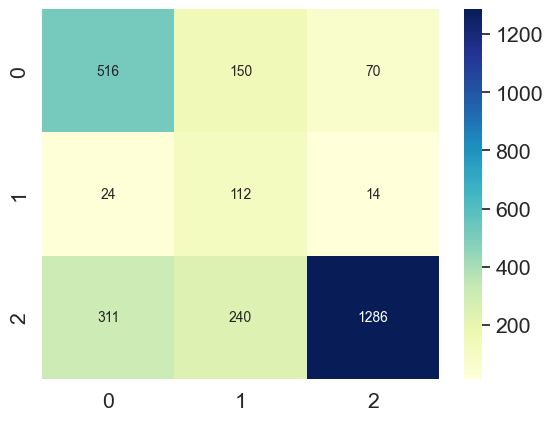

[1:END] Validation loss improved, saved model to ./runs/2/1679587975.7776968_BERTGRUSentiment_weighted/model_1.pth


  0%|          | 0/335 [00:00<?, ?it/s]

[2:40] Loss: 0.669
[2:80] Loss: 0.578
[2:120] Loss: 0.635
[2:160] Loss: 0.604
[2:200] Loss: 0.575
[2:240] Loss: 0.648
[2:280] Loss: 0.563
[2:320] Loss: 0.540
[2:END] Took 269.420s
[2:END] Training Loss: 0.598


  0%|          | 0/86 [00:00<?, ?it/s]

[2:END] Validation Loss: 0.593
[2:END] Validation Accuracy: 78.039%
              precision    recall  f1-score   support

           0       0.66      0.83      0.74       736
           1       0.34      0.71      0.46       150
           2       0.95      0.76      0.85      1837

    accuracy                           0.78      2723
   macro avg       0.65      0.77      0.68      2723
weighted avg       0.84      0.78      0.80      2723



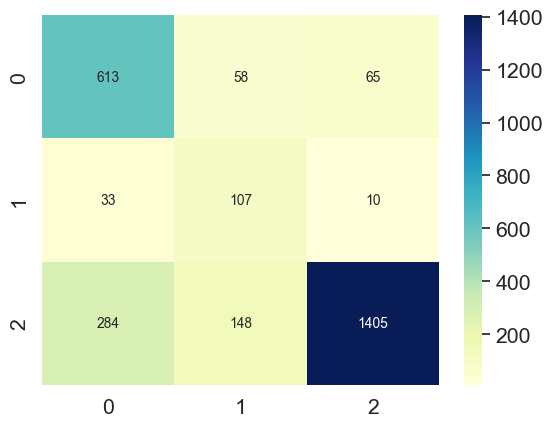

[2:END] Validation loss improved, saved model to ./runs/2/1679587975.7776968_BERTGRUSentiment_weighted/model_2.pth


  0%|          | 0/335 [00:00<?, ?it/s]

[3:40] Loss: 0.451
[3:80] Loss: 0.470
[3:120] Loss: 0.389
[3:160] Loss: 0.407
[3:200] Loss: 0.446
[3:240] Loss: 0.349
[3:280] Loss: 0.450
[3:320] Loss: 0.420
[3:END] Took 269.020s
[3:END] Training Loss: 0.423


  0%|          | 0/86 [00:00<?, ?it/s]

[3:END] Validation Loss: 0.686
[3:END] Validation Accuracy: 72.237%
              precision    recall  f1-score   support

           0       0.54      0.87      0.67       736
           1       0.38      0.76      0.51       150
           2       0.98      0.66      0.79      1837

    accuracy                           0.72      2723
   macro avg       0.63      0.76      0.65      2723
weighted avg       0.83      0.72      0.74      2723



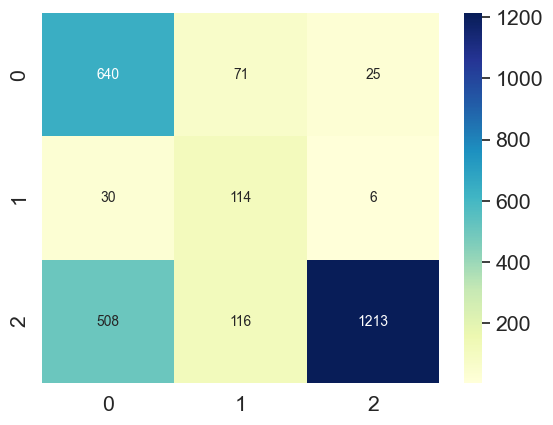

  0%|          | 0/335 [00:00<?, ?it/s]

[4:40] Loss: 0.305
[4:80] Loss: 0.298
[4:120] Loss: 0.277
[4:160] Loss: 0.255
[4:200] Loss: 0.324
[4:240] Loss: 0.302
[4:280] Loss: 0.316
[4:320] Loss: 0.276
[4:END] Took 277.464s
[4:END] Training Loss: 0.294


  0%|          | 0/86 [00:00<?, ?it/s]

[4:END] Validation Loss: 0.632
[4:END] Validation Accuracy: 83.474%
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       736
           1       0.43      0.64      0.52       150
           2       0.93      0.87      0.90      1837

    accuracy                           0.83      2723
   macro avg       0.70      0.77      0.73      2723
weighted avg       0.85      0.83      0.84      2723



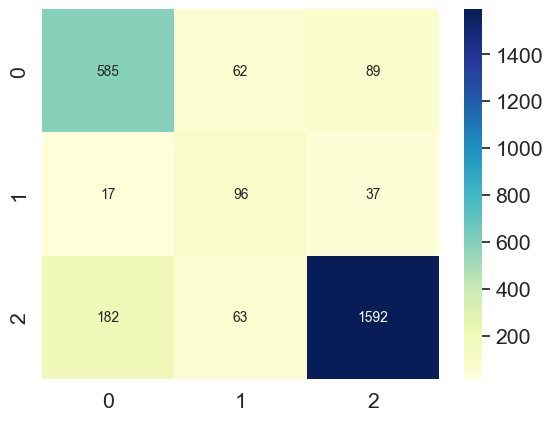

  0%|          | 0/335 [00:00<?, ?it/s]

[5:40] Loss: 0.202
[5:80] Loss: 0.195
[5:120] Loss: 0.204
[5:160] Loss: 0.186
[5:200] Loss: 0.225
[5:240] Loss: 0.223
[5:280] Loss: 0.235
[5:320] Loss: 0.241
[5:END] Took 269.184s
[5:END] Training Loss: 0.216


  0%|          | 0/86 [00:00<?, ?it/s]

[5:END] Validation Loss: 0.628
[5:END] Validation Accuracy: 80.059%
              precision    recall  f1-score   support

           0       0.65      0.84      0.73       736
           1       0.45      0.77      0.57       150
           2       0.95      0.79      0.86      1837

    accuracy                           0.80      2723
   macro avg       0.69      0.80      0.72      2723
weighted avg       0.84      0.80      0.81      2723



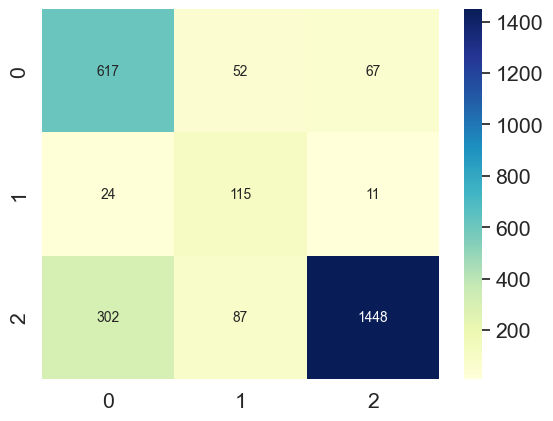

  0%|          | 0/335 [00:00<?, ?it/s]

[6:40] Loss: 0.192
[6:80] Loss: 0.186
[6:120] Loss: 0.195
[6:160] Loss: 0.137
[6:200] Loss: 0.197
[6:240] Loss: 0.211
[6:280] Loss: 0.147
[6:320] Loss: 0.166
[6:END] Took 269.345s
[6:END] Training Loss: 0.180


  0%|          | 0/86 [00:00<?, ?it/s]

[6:END] Validation Loss: 0.693
[6:END] Validation Accuracy: 85.017%
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       736
           1       0.50      0.72      0.59       150
           2       0.92      0.89      0.90      1837

    accuracy                           0.85      2723
   macro avg       0.74      0.79      0.76      2723
weighted avg       0.86      0.85      0.85      2723



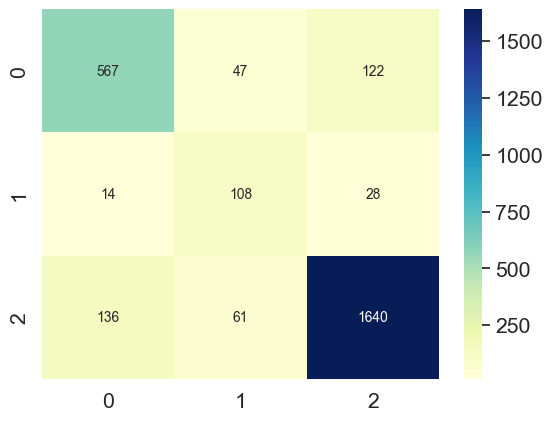

[END] Stopping early as validation loss hasn't improved in 4 epochs
Training complete


In [222]:
best_validation_loss = 1e9
save_path = f"./runs/2/{time.time()}_{model.__class__.__qualname__}_{'weighted' if apply_loss_weighting else 'no_weight'}"
epochs_since_best_validation = 0

os.makedirs(save_path, exist_ok=True)

if not apply_loss_weighting:
    loss_func = nn.CrossEntropyLoss()
else:
    loss_func = nn.CrossEntropyLoss(weight=class_weights.float().to(device))
    
for epoch in range(1, 101):
    model.train()
    epoch_st = time.time()
    epoch_loss = 0
    
    batch_acc_loss = 0
    
    for batch_no, (inp, labels) in enumerate(tqdm(train_dataloader)):
        inp = inp.to(device)
        labels = labels.to(device).squeeze()
        
        # print(inp.shape, labels.shape)

        predictions = model(inp)
        loss = loss_func(predictions, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_loss += loss.item()
        batch_acc_loss += loss.item()

        if batch_no != 0 and batch_no % 40 == 0:
            print(f"[{epoch}:{batch_no}] Loss: {(batch_acc_loss / 40):.3f}")
            batch_acc_loss = 0

    epoch_dt = time.time() - epoch_st
    print(f"[{epoch}:END] Took {epoch_dt:.3f}s")
    print(f"[{epoch}:END] Training Loss: {(epoch_loss / len(train_dataloader)):.3f}")
    
    validation_pred, avg_validation_loss = evaluate_model(model, val_dataloader, val_labels, apply_loss_weighting)
    print(f"[{epoch}:END] Validation Loss: {avg_validation_loss:.3f}")
    print(f"[{epoch}:END] Validation Accuracy: {(validation_pred == val_labels).mean() * 100:.3f}%")
    
    print(metrics.classification_report(val_labels, validation_pred))
    plot_confusion_matrix(val_labels, validation_pred) 
    # plot_roc_curve(val_labels, validation_pred) # meaningless for multi-class
    
    epochs_since_best_validation += 1
    
    if avg_validation_loss < best_validation_loss:
        epochs_since_best_validation = 0
        best_validation_loss = avg_validation_loss
        torch.save(model.state_dict(), f"{save_path}/model_{epoch}.pth")
        print(f"[{epoch}:END] Validation loss improved, saved model to {save_path}/model_{epoch}.pth")
    
    if epochs_since_best_validation >= 4:
        print(f"[END] Stopping early as validation loss hasn't improved in 4 epochs")
        break
        
print("Training complete")